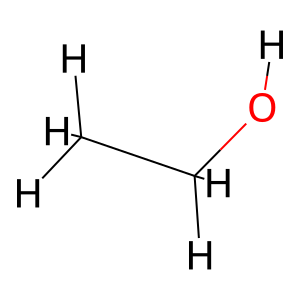

In [14]:
from rdkit import Chem
from rdkit.Chem import Draw

# Define the SMILES string
smiles = 'CCO'  # Example: Ethanol

# Create a molecule object from the SMILES string
molecule = Chem.MolFromSmiles(smiles)

# Add hydrogens to the molecule
molecule = Chem.AddHs(molecule)

# Generate 3D coordinates
AllChem.EmbedMolecule(molecule, randomSeed=42)
AllChem.UFFOptimizeMolecule(molecule)

# Display the molecule
Draw.MolToImage(molecule)

In [17]:
from ase import Atoms
import nglview as nv

# Function to convert RDKit molecule to ASE Atoms object
def rdkit_to_ase(molecule):
    conformer = molecule.GetConformer()
    symbols = [atom.GetSymbol() for atom in molecule.GetAtoms()]
    positions = [conformer.GetAtomPosition(atom.GetIdx()) for atom in molecule.GetAtoms()]
    positions = [(pos.x, pos.y, pos.z) for pos in positions]
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms

at = rdkit_to_ase(molecule)
nv.show_ase(ase_atoms)

NGLWidget()